In [2]:
#下载数据
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #设置选项允许重复加载动态链接库。



In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [5]:
#使用pandas读入并处理数据

import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l



In [6]:
#使用上面定义的脚本下载并缓存Kaggle房屋数据集
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
#使用pandas分别加载包含训练数据和测试数据的两个CSV文件
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
#1460样本，81维度

#看一下数据的样子，前四个和最后两个特征，以及相应的标签
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [9]:
#将第一个特征ID从数据集中删除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [10]:
#将所有缺失的值替换为相应的特征的平均值。通过将特征的重新缩放到零均值和单位方差来标准化数据

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  #筛选那些是数值特征，哪些是文本特征
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean()) / (x.std()))  #.mean()均值
all_features[numeric_features] = all_features[numeric_features].fillna(0)  #把NAN改成0
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0

In [11]:
#处理离散值，用一次独热编码来替换他们

all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [12]:
#从pamdas格式中提取numpy格式，并将其转换为张量来表示

n_train = train_data.shape[0]  #shape[0]数据的行数
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [13]:
#训练
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))   #使用单层线性回归模型，这个模型将作为beseline用来对比
    return net

In [14]:
#房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。 更关心相对误差
def log_rmse(net,features,labels):
    clipped_preds = torch.clamp(net(features),1,float('inf'))  
    #torch.clamp(input, min, max, out=None)
    # 限幅。将input的值限制在[min, max]之间，并返回结果。out (Tensor, optional) – 输出张量，一般用不到该参数。
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))#label是价格
    return rmse.item()



In [15]:
#训练函数将借助Adam优化器 ，Adam优化器的主要吸引力在于它对初始学习率不那么敏感。
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [16]:
#K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k   #样本数除以K，假如100样本，k=5，那么foldsize=20
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  #每20一份切片
        X_part, y_part = X[idx, :], y[idx]  #取出对应的切片部分
        if j == i:   #如果j=i，就把这一分做成验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
            #C = torch.cat( (A,B),0 )  #按维数0拼接（竖着拼）
            #C = torch.cat( (A,B),1 )  #按维数1拼接（横着拼）
    return X_train, y_train, X_valid, y_valid   #返回训练集和验证集

In [17]:
#返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.169637, 验证log rmse0.157162
折2，训练log rmse0.162417, 验证log rmse0.190584
折3，训练log rmse0.164243, 验证log rmse0.168338
折4，训练log rmse0.167572, 验证log rmse0.154563
折5，训练log rmse0.162866, 验证log rmse0.182773
5-折验证: 平均训练log rmse: 0.165347, 平均验证log rmse: 0.170684


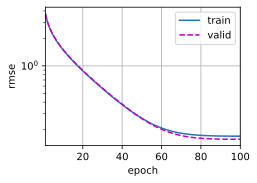

In [18]:
#模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [19]:
#提交kaggle预测
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162616


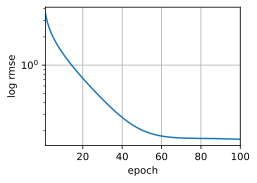

In [20]:
#如果测试集上的预测与倍交叉验证过程中的预测相似， 那就是时候把它们上传到Kaggle了
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)